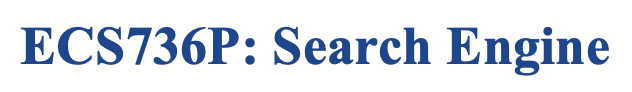

# **Introduction:**

This google colab notebook demonstrates the implementation of our search engine. This is a key component of the practical coursework 3 for the ECS736P (Information Retrieval) module.

The primary aim of the search engine is to facilitate users in accessing relevant recipes based on their queries.

***By Group 4 - Malaika, Khushboo & Drishti***



------

# **Contents:**
1. Data Preparation
      - 1.1 Importing Dataset in Notebook
      - 1.2 Dataset Exploration
      - 1.3 Cleaning Dataset

2. Indexing Module
    - 2.1 Text Preprocessing
    - 2.2 Count Vectorisation
    - 2.3 Regular Expression

3. Retrieval Method
  - 3.1 BM25 Implementation

4. Evaluation
  - 4.1 Obtaining Recipes
  - 4.2 Obtaining random ingredients
  - 4.3 Obtaining ground truths
  - 4.4 Using the search engine to retrieve bm25 scores
  - 4.5 Obtaining precison, recall and F1 score
  - 4.6 Analysis

5. User Interface








---------
# **1. Data Preparation**

**1.1 Importing Dataset in Notebook**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# @title
import pandas as pd

# Replace the path below with the exact path where your file is located in your Google Drive
file_path = '/content/drive/My Drive/recipes.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to ensure it's loaded correctly
data.head()


,Unnamed: 0,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,cuisine_path,nutrition,timing,img_src
0,0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,"Total Fat 18g 23%, Saturated Fat 7g 34%, Chole...","Servings: 8, Yield: 6 to 8 - servings",https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...
1,1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 19g 24%, Saturated Fat 9g 46%, Chole...","Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...
2,2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,"Total Fat 0g 0%, Sodium 3mg 0%, Total Carbohyd...","Prep Time: 10 mins, Cook Time: 15 mins, Total ...",https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...
3,3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,"Total Fat 8g 11%, Saturated Fat 5g 25%, Choles...","Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...
4,4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 0g 0%, Sodium 61mg 3%, Total Carbohy...","Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...


**1.2 Dataset Exploration**

In [ ]:
len(data.index)

1090

In [ ]:
# Get a summary of missing values
print(data.isnull().sum())

Unnamed: 0        0
recipe_name       0
prep_time        51
cook_time       308
total_time       45
servings          0
yield           211
ingredients       0
directions        0
rating            0
url               0
cuisine_path      0
nutrition         0
timing            0
img_src           0
dtype: int64


In [ ]:
data = data.drop(['Unnamed: 0','yield','total_time','timing'], axis=1)

**1.2 Cleaning Dataset**

In [ ]:

import numpy as np



# Handle Missing Values for 'prep_time' and 'cook_time'
# First convert all time to minutes
def convert_to_minutes(s):
    if pd.isnull(s):
        return None
    total_time = 0
    # Check for hours and minutes using 'hrs' and 'mins' as identifiers
    if 'hrs' in s or 'hr' in s:
        # Extract the hours part and convert to minutes
        hours = s.split('hrs')[0].split('hr')[0].strip()
        total_time += int(hours) * 60
        # Remove the hours part from the string to leave only minutes
        s = s.split('hrs')[1] if 'hrs' in s else s.split('hr')[1]
    if 'mins' in s or 'min' in s:
        # Extract the minutes part
        minutes = s.split('mins')[0].split('min')[0].strip()
        total_time += int(minutes)
    return total_time


# Assume 'data' is your DataFrame and the 'total_time' column has been removed

# Convert the 'prep_time' and 'cook_time' columns to minutes using your conversion function if not already done
data['prep_time'] = data['prep_time'].map(convert_to_minutes)
data['cook_time'] = data['cook_time'].map(convert_to_minutes)

# Calculate median values for 'prep_time' and 'cook_time'
prep_median = data['prep_time'].median()
cook_median = data['cook_time'].median()

# Replace NA values in 'prep_time' and 'cook_time' with the median values
data['prep_time'].fillna(prep_median, inplace=True)
data['cook_time'].fillna(cook_median, inplace=True)

# Create a new 'total_time' column as the sum of 'prep_time' and 'cook_time'
data['total_time'] = data['prep_time'] + data['cook_time']




# Clean 'ingredients' and 'directions' text data
# This would be specific to what you find in the text
# Example for 'ingredients': lowercasing, removing extra spaces, etc.
data['ingredients'] = data['ingredients'].str.lower().str.strip()
data['directions'] = data['directions'].str.lower().str.strip()

In [ ]:
data.isnull().sum()

recipe_name     0
prep_time       0
cook_time       0
servings        0
ingredients     0
directions      0
rating          0
url             0
cuisine_path    0
nutrition       0
img_src         0
total_time      0
dtype: int64

In [ ]:
data = data.drop(columns = 'nutrition')
data.head(5)

,recipe_name,prep_time,cook_time,servings,ingredients,directions,rating,url,cuisine_path,img_src,total_time
0,Apple-Cranberry Crostada,15.0,30.0,8,"3 tablespoons butter, 2 pounds granny smith ap...",heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,45.0
1,Apple Pie by Grandma Ople,30.0,60.0,8,"8 small granny smith apples, or as needed, ½ c...","peel and core apples, then thinly slice. set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,90.0
2,Sarah's Homemade Applesauce,10.0,15.0,4,"4 apples - peeled, cored and chopped, ¾ cup w...","combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,25.0
3,Apple Crisp,30.0,45.0,12,"10 cups all-purpose apples, peeled, cored and ...",preheat the oven to 350 degrees f (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,75.0
4,Apple Pie Filling,20.0,20.0,40,"18 cups thinly sliced apples, 3 tablespoons le...",toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,40.0


In [ ]:
# Save the processed data for use in the search engine
processed_file_path = '/content/drive/My Drive/processed_recipes.csv'
data.to_csv(processed_file_path, index=False)

# Load the dataset
data = pd.read_csv(processed_file_path)

# Display the first few rows of the dataset to ensure it's loaded correctly
data.head()

,recipe_name,prep_time,cook_time,servings,ingredients,directions,rating,url,cuisine_path,img_src,total_time
0,Apple-Cranberry Crostada,15.0,30.0,8,"3 tablespoons butter, 2 pounds granny smith ap...",heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,45.0
1,Apple Pie by Grandma Ople,30.0,60.0,8,"8 small granny smith apples, or as needed, ½ c...","peel and core apples, then thinly slice. set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,90.0
2,Sarah's Homemade Applesauce,10.0,15.0,4,"4 apples - peeled, cored and chopped, ¾ cup w...","combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,25.0
3,Apple Crisp,30.0,45.0,12,"10 cups all-purpose apples, peeled, cored and ...",preheat the oven to 350 degrees f (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,75.0
4,Apple Pie Filling,20.0,20.0,40,"18 cups thinly sliced apples, 3 tablespoons le...",toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,40.0


In [ ]:
len(data)

1090

-------
# **2. Indexing Module**

**2.1 Text Preprocessing**

In [ ]:
pip install nltk scikit-learn

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Decided to use Lemmatization over Stemming because Lemmatization is more accurate than stemming since it reduces words to thier canonical form (lemma) which results in a real word.

This process considers the context of the word in the sentence and applies morphological analysis to determine the lemma.

It is curuical to preserve the meaning and correctness of words because the search engine is using a recipe dataset to meet user query.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmitization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Reconstruct text
    preprocessed_text = " ".join(lemmatized_tokens)

    return preprocessed_text

# Apply preprocessing to the 'ingredients' column
data['preprocessed_ingredients'] = data['ingredients'].apply(preprocess_text)

In [ ]:
# Print 'ingredients' column before preprocessing
print("Before preprocessing:")
print(data['ingredients'].head())

# Apply preprocessing to the 'ingredients' column
data['ingredients'] = data['ingredients'].apply(preprocess_text)

# Print 'ingredients' column after preprocessing
print("\nAfter preprocessing:")
print(data['preprocessed_ingredients'].head())

Before preprocessing:
0    3 tablespoons butter, 2 pounds granny smith ap...
1    8 small granny smith apples, or as needed, ½ c...
2    4  apples - peeled, cored and chopped, ¾ cup w...
3    10 cups all-purpose apples, peeled, cored and ...
4    18 cups thinly sliced apples, 3 tablespoons le...
Name: ingredients, dtype: object

After preprocessing:
0    3 tablespoon butter , 2 pound granny smith app...
1    8 small granny smith apple , needed , ½ cup un...
2    4 apple - peeled , cored chopped , ¾ cup water...
3    10 cup all-purpose apple , peeled , cored slic...
4    18 cup thinly sliced apple , 3 tablespoon lemo...
Name: preprocessed_ingredients, dtype: object


In [ ]:
data = data[data['preprocessed_ingredients'].str.count(',') >= 4]

**2.2 Count Vectorization:**

In [ ]:
vectorizer = CountVectorizer(token_pattern='[a-z]+').fit(data['preprocessed_ingredients'])

vocab = vectorizer.get_feature_names_out()

dtm = vectorizer.transform(data['preprocessed_ingredients'])

df_dtm = pd.DataFrame(dtm.toarray(), columns = vocab)

df_dtm

,absolut,achiote,acinus,active,additional,adjust,adobo,agave,aged,ale,...,wrapped,yeast,yellow,yogurt,yolk,young,zest,zested,ziyad,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_dtm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Columns: 1012 entries, absolut to zucchini
dtypes: int64(1012)
memory usage: 7.8 MB


In [ ]:
df_dtm.iloc[2].sort_values(ascending=False).head(5)

cup         2
white       1
water       1
teaspoon    1
cinnamon    1
Name: 2, dtype: int64

In [ ]:
tfs = df_dtm.div(df_dtm.sum(axis=1), axis=0)
tfs

,absolut,achiote,acinus,active,additional,adjust,adobo,agave,aged,ale,...,wrapped,yeast,yellow,yogurt,yolk,young,zest,zested,ziyad,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**2.3 Regular Expression:**

Using Regular Expression to remove numeric values in the ingredients section that might cause problems later on during retreival.

In [ ]:
data = data.drop(columns = 'ingredients')

In [ ]:
fractions_to_remove = ["¼ pound", "¼ fresh", "½", "⅛", "¾", "¼", "⅓", '.', "( fl oz )", '½ cup', "½ ounce  %", '½ tablespoon', '⅛ teaspoon', '¾ cup', '¼ cup', '1 ½ cups', '1 ⅓ cups' '2 ½ cups', '1 ¾ cups', '2 ¾ cups', '⅔ cup', '2 ⅓ cups', '1 ¼ cups', '2 ¼ cups', '¼ teaspoon',  '½ teaspoon', '½ pound', '⅓ cup']

for fraction in fractions_to_remove:
    data['preprocessed_ingredients'] = data['preprocessed_ingredients'].str.replace(fraction, '')

data.head(5)

,recipe_name,prep_time,cook_time,servings,directions,rating,url,cuisine_path,img_src,total_time,preprocessed_ingredients
0,Apple-Cranberry Crostada,15.0,30.0,8,heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,45.0,"3 tablespoon butter , 2 pound granny smith app..."
1,Apple Pie by Grandma Ople,30.0,60.0,8,"peel and core apples, then thinly slice. set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,90.0,"8 small granny smith apple , needed , cup uns..."
2,Sarah's Homemade Applesauce,10.0,15.0,4,"combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,25.0,"4 apple - peeled , cored chopped , cup water ..."
3,Apple Crisp,30.0,45.0,12,preheat the oven to 350 degrees f (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,75.0,"10 cup all-purpose apple , peeled , cored slic..."
4,Apple Pie Filling,20.0,20.0,40,toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,40.0,"18 cup thinly sliced apple , 3 tablespoon lemo..."


In [ ]:
import re

def remove_numeric_and_metric(text):
    # List of metric units including "cup"
    metric_units = ["( .ounce)", "( ounce )", 'ounce', "pound", "tablespoon", "tbsp", "teaspoon", "tsp", "cup", "cups", "grams", "g", "kilograms", "kg", "milliliters", "ml", "liters", "l", "centimeters", "cm", "millimeters", "mm"]

    # Define a regular expression pattern to match numeric values, fractions, and the word "cup"
    pattern = r'\b\d+(\s+\d+/\d+)?(/\d+)?\s*(?:' + '|'.join(metric_units) + r')?\b'

    # Remove specific substrings excluding commas
    specific_substrings = r'\( -?inch \)|\( inch \)|\( \.ounce\)|\( ounce \)|ounce|\( pound \)|\(|\)|\(\.\s*\)'
    cleaned_text = re.sub(pattern + '|' + specific_substrings, '', text)

    return cleaned_text

# Apply the function to 'preprocessed_ingredients' column
data['preprocessed_ingredients'] = data['preprocessed_ingredients'].apply(remove_numeric_and_metric)

# Display the modified DataFrame
data.head(5)



,recipe_name,prep_time,cook_time,servings,directions,rating,url,cuisine_path,img_src,total_time,preprocessed_ingredients
0,Apple-Cranberry Crostada,15.0,30.0,8,heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,45.0,"butter , granny smith apple firm , crisp ap..."
1,Apple Pie by Grandma Ople,30.0,60.0,8,"peel and core apples, then thinly slice. set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,90.0,"small granny smith apple , needed , cup unsal..."
2,Sarah's Homemade Applesauce,10.0,15.0,4,"combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,25.0,"apple - peeled , cored chopped , cup water , ..."
3,Apple Crisp,30.0,45.0,12,preheat the oven to 350 degrees f (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,75.0,"all-purpose apple , peeled , cored sliced , ..."
4,Apple Pie Filling,20.0,20.0,40,toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,40.0,"thinly sliced apple , lemon juice , water ,..."


In [ ]:
# Save the processed data for use in the search engine
processed_file = '/content/drive/My Drive/processed_recipes_re.csv'
data.to_csv(processed_file, index=False)

# Load the dataset
data = pd.read_csv(processed_file)

# Display the first few rows of the dataset to ensure it's loaded correctly
data.head()

,recipe_name,prep_time,cook_time,servings,directions,rating,url,cuisine_path,img_src,total_time,preprocessed_ingredients
0,Apple-Cranberry Crostada,15.0,30.0,8,heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,45.0,"butter , granny smith apple firm , crisp ap..."
1,Apple Pie by Grandma Ople,30.0,60.0,8,"peel and core apples, then thinly slice. set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,90.0,"small granny smith apple , needed , cup unsal..."
2,Sarah's Homemade Applesauce,10.0,15.0,4,"combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,25.0,"apple - peeled , cored chopped , cup water , ..."
3,Apple Crisp,30.0,45.0,12,preheat the oven to 350 degrees f (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,75.0,"all-purpose apple , peeled , cored sliced , ..."
4,Apple Pie Filling,20.0,20.0,40,toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,40.0,"thinly sliced apple , lemon juice , water ,..."


In [ ]:
data['preprocessed_ingredients']

0        butter ,  granny smith apple  firm , crisp ap...
1       small granny smith apple , needed ,  cup unsal...
2       apple - peeled , cored chopped ,  cup water , ...
3        all-purpose apple , peeled , cored sliced ,  ...
4        thinly sliced apple ,  lemon juice ,  water ,...
                              ...                        
1010     butter ,  pitted chopped date ,  white sugar ...
1011     white sugar ,  vegetable oil ,  chopped pecan...
1012    fresh hot chile pepper , stem removed , onion ...
1013     chopped date ,  cup butter ,  boiling water ,...
1014     pitted medjool date , roughly chopped ,  raw ...
Name: preprocessed_ingredients, Length: 1015, dtype: object

*****************

# **3. Retrieval Method**

**3.1 BM25 Implementation**

In [ ]:
dfs = np.zeros(len(vocab))

# Calculate DF for each term
for i, term in enumerate(vocab):
    for document in data['preprocessed_ingredients']:
        if term in document:
            dfs[i] += 1
print(dfs.shape, dfs)

# then calculate idf:
N = len(data)

# Calculate IDF for each term
idfs = np.log(N / dfs)

print(idfs.shape, idfs)

(1012,) [ 1.  2.  3. ... 10.  1.  3.]
(1012,) [6.92264389 6.22949671 5.8240316  ... 4.6200588  6.92264389 5.8240316 ]


<ipython-input-66-25e29553cfac>:14: RuntimeWarning: divide by zero encountered in divide
  idfs = np.log(N / dfs)


In [ ]:
tf_idf = dfs * idfs
tf_idf

<ipython-input-67-983c0e323140>:1: RuntimeWarning: invalid value encountered in multiply
  tf_idf = dfs * idfs


array([ 6.92264389, 12.45899342, 17.47209481, ..., 46.20058798,
        6.92264389, 17.47209481])

In [ ]:
# Next let's get have a look at the term frequencies and turn them into BM25 term frequencies.

# Let's first define all the variables we need:
k_1 = 1.2  # single value (default)
b = 0.8  # single value (default)
dls = np.array([len(document) for document in data['preprocessed_ingredients']])
avgdl = np.mean(dls)

print(k_1, b, dls, avgdl)

1.2 0.8 [411 178  90 ... 289 161 313] 189.0630541871921


In [ ]:
(k_1 * ((1 - b) + b * (dls/avgdl))).reshape(1015,1).shape

(1015, 1)

In [ ]:
len(data)

1015

In [ ]:
numerator = np.array((k_1 + 1) * tfs)
denominator = (k_1 * ((1 - b) + b * (dls/avgdl))).reshape(-1, 1) + tfs

BM25_tf = numerator / denominator

BM25_score = idfs * np.array(BM25_tf)

<ipython-input-71-a4481e04d21a>:6: RuntimeWarning: invalid value encountered in multiply
  BM25_score = idfs * np.array(BM25_tf)


In [ ]:
BM25_tf.shape

(1015, 1012)

In [ ]:
bm25_dataframe = pd.DataFrame(BM25_score, columns=vocab)
bm25_dataframe

,absolut,achiote,acinus,active,additional,adjust,adobo,agave,aged,ale,...,wrapped,yeast,yellow,yogurt,yolk,young,zest,zested,ziyad,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


********************

# **4. Evaluation**

**4.1 Obtaining recipes**

In [ ]:
def search_recipes(filtered_expanded_terms, data, case_label='case 1'):
    # Initialize a dictionary to store results under different cases
    results = {case_label: []}

    for idx, row in data.iterrows():
        recipe_ingredients = row['preprocessed_ingredients'].split(',')
        recipe_ingredients = [ingredient.strip().lower() for ingredient in recipe_ingredients]

        # Check if any of the filtered expanded terms are present in recipe ingredients
        if any(recipe_ingredient in recipe_ingredients for recipe_ingredient in filtered_expanded_terms):
            results[case_label].append(row['recipe_name'])

    return results

**4.2 Obtaining random ingredients that are definately in the dataset**

In [ ]:
import random
# Splitting the preprocessed ingredients into individual ingredients
individual_ingredients = set()
for ingredients in data['preprocessed_ingredients']:

    for ingredient in ingredients.split(','):
        cleaned_ingredient = ingredient.strip().lower()
        if cleaned_ingredient:
            individual_ingredients.add(cleaned_ingredient)

# Creating a list from the set of individual ingredients for easier indexing
individual_ingredients_list = list(individual_ingredients)

# Randomly selecting 30 sets of 5 ingredients each to form query pairs
ingredients_random = [random.sample(individual_ingredients_list, 5) for _ in range(30)]

# Display the first few query pairs to check
ingredients_random[:5]

[['cup coarsely crushed corn chip',
  'pumpkin seed',
  'drumstick',
  'cup crumbled blue cheese',
  'cup alfalfa sprout  optional'],
 ['french bread',
  'blanched slivered',
  'fresh lemon juice',
  'sliced round',
  'butter margarine'],
 ['freshly ground cardamom',
  'whipped',
  'slice day-old bread',
  'peeled cored',
  'cup cubed apple  optional'],
 ['butternut squash- peeled',
  'small red hot chile pepper',
  'cod',
  'prosciutto',
  'peanut butter'],
 ['cup old-fashioned rolled oat',
  'pint fresh raspberry',
  'chopped cooked chicken',
  'grapeseed oil olive oil',
  'pinch ground nutmeg  optional']]

**4.3 Obtaining ground truths for a combination of ingredients that are definately in the data.**

In [ ]:
from nltk.corpus import wordnet
from collections import OrderedDict
import pandas as pd

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word, pos=wordnet.NOUN):  # Focusing on nouns for ingredients
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)

def search_recipes(filtered_expanded_terms, data):
    relevant_recipes = []
    for idx, row in data.iterrows():
        recipe_ingredients = row['preprocessed_ingredients'].split(',')
        recipe_ingredients = [ingredient.strip().lower() for ingredient in recipe_ingredients]
        if any(term in recipe_ingredients for term in filtered_expanded_terms):
            relevant_recipes.append(row['recipe_name'])
    return relevant_recipes

queries = {
    'case 1': ['egg', 'sugar', 'banana', 'flour', 'milk'],
    'case 2': ['apple', 'egg', 'milk', 'flour', 'nut'],
    'case 3': ['pork', 'apple', 'sage', 'onion'],
    'case 4': ['banana', 'walnut', 'cinnamon', 'flour'],
    'case 5': ['ham', 'tomato', 'onion', 'salt'],
    'case 6': ['pineapple', 'rum', 'mint', 'lime', 'soda'],
    'case 7': ['basil', 'garlic', 'tomato', 'marinara'],
    'case 8': ['cheese', 'mushroom', 'chicken', 'thyme'],
    'case 9': ['mango', 'lime', 'chilli', 'salt'],
    'case 10': ['chilli', 'cocoa', 'bean', 'cumin'],
    'case 11': ['plum', 'sugar', 'butter', 'flour'],
    'case 12': ['rice', 'lemon', 'lime', 'soda', 'alfalfa', 'salt'],
    'case 13': ['mango', 'cherry', 'bean', 'lime', 'cilantro'],
    'case 14': ['chicken', 'garlic', 'ginger', 'rice'],
    'case 15': ['lamb', 'rosemary', 'yogurt', 'garlic'],
    'case 16': ['fish', 'spinach', 'cilantro', 'chilli', 'oil'],
    'case 17': ['pork', 'sage', 'vinegar', 'salt', 'pepper'],
    'case 18': ['walnut', 'coconut', 'oat', 'honey', 'cranberry', 'strawberry'],
    'case 19': ['coconut', 'milk', 'sunflower', 'seed', 'jalapeno', 'chickpea', 'cherry'],
    'case 20': ['water', 'oat', 'sugar', 'strawberry', 'milk'],
    'case 21': ['passion', 'mint', 'avocado', 'peach', 'honey'],
    'case 22': ['avocado', 'lemon', 'quinoa', 'spinach', 'feta', 'cheese'],
    'case 23': ['potato', 'corn', 'tortilla', 'coriander', 'ginger'],
    'case 24': ['date', 'vanilla', 'yogurt', 'basil', 'balsamic', 'vinaigrette', 'vinegar'],
    'case 25': ['bread', 'sugar', 'salsa', 'baguette', 'yeast'],
    'case 26': ['beef', 'onion', 'pepper', 'rice', 'broth'],
    'case 27': ['apricot', 'chicken', 'thyme', 'yogurt', 'almond'],
    'case 28': ['orange', 'cracker', 'coconut', 'honey', 'ricotta'],
    'case 29': ['potato', 'carrot', 'peas', 'chilli', 'tomato'],
    'case 30': ['chicken', 'broth', 'shallot', 'cream', 'mushroom']
}

# Dictionary to store results for each case
results = {}

# Dictionary to store results with ingredients as keys
results_with_ingredients = {}

for case, ingredients in queries.items():
    expanded_terms = ingredients.copy()
    for ingredient in ingredients:
        synonyms = get_synonyms(ingredient)
        expanded_terms += synonyms
    expanded_terms = list(OrderedDict.fromkeys(expanded_terms))

    relevant_recipes = search_recipes(expanded_terms, data)
    # Use ingredients list as string for key
    ingredients_key = ', '.join(ingredients)
    results_with_ingredients[ingredients_key] = relevant_recipes

# Convert the updated results dictionary to a list of tuples
data_flattened = [(ingredients, recipe) for ingredients, recipes in results_with_ingredients.items() for recipe in recipes]

# Convert to DataFrame
ground_truth_df = pd.DataFrame(data_flattened, columns=['Ingredients', 'Recipe'])

In [ ]:
ground_truth_df

,Ingredients,Recipe
0,"egg, sugar, banana, flour, milk",Apple-Cranberry Crostada
1,"egg, sugar, banana, flour, milk",Apple Turnovers
2,"egg, sugar, banana, flour, milk",Caramel Apples
3,"egg, sugar, banana, flour, milk",German Apple Cake
4,"egg, sugar, banana, flour, milk",Apple Hand Pies
...,...,...
2207,"chicken, broth, shallot, cream, mushroom",Smokey Butternut Squash Soup
2208,"chicken, broth, shallot, cream, mushroom",Holiday Pomegranate Mignonette
2209,"chicken, broth, shallot, cream, mushroom",Pomegranate Relish
2210,"chicken, broth, shallot, cream, mushroom",Healthy Apple and Kale Salad


**4.4 Using search enginge to retrieve recipes from the dataset.**

In [ ]:
def test_search(ingredients, sort_criterion = 'score', sort_order = 'desc'):
    q_terms = [term.strip() for term in ingredients]

    # Expand query terms with synonyms
    expanded_terms = q_terms.copy()
    for term in q_terms:
        synonyms = get_synonyms(term)
        expanded_terms += synonyms
    expanded_terms = list(OrderedDict.fromkeys(expanded_terms))

    # Filter expanded terms by what's available in bm25_dataframe
    filtered_expanded_terms = [term for term in expanded_terms if term in bm25_dataframe.columns]

    # Compute relevance scores for each reciphe
    expanded_terms_df = bm25_dataframe[filtered_expanded_terms]
    score_q_d = expanded_terms_df.sum(axis=1)


    recipe_names = data['recipe_name'].values
    scores_with_names = list(zip(recipe_names, score_q_d))

    return scores_with_names

results_data = []

for query in queries.values():
    ranked_docs = test_search(query)
    for name, score in ranked_docs:
        query_str = ', '.join(query)  # Convert the query list to a string
        results_data.append({
            "Query Ingredients": query_str,
            "Recipe Name": name,
            "Score": score
        })

# Convert the structured data into a DataFrame
final_df = pd.DataFrame(results_data)
final_df

,Query Ingredients,Recipe Name,Score
0,"egg, sugar, banana, flour, milk",Apple-Cranberry Crostada,0.031602
1,"egg, sugar, banana, flour, milk",Apple Pie by Grandma Ople,0.128083
2,"egg, sugar, banana, flour, milk",Sarah's Homemade Applesauce,0.092386
3,"egg, sugar, banana, flour, milk",Apple Crisp,0.105921
4,"egg, sugar, banana, flour, milk",Apple Pie Filling,0.042500
...,...,...,...
30445,"chicken, broth, shallot, cream, mushroom",Date-Nut Balls,0.000000
30446,"chicken, broth, shallot, cream, mushroom",Jamaica Cake,0.000000
30447,"chicken, broth, shallot, cream, mushroom",Best Hot Sauce,0.000000
30448,"chicken, broth, shallot, cream, mushroom",Moist Date Nut Bread,0.000000


**4.5 Obtaining Precision, Recall and F1 score**

In [ ]:
import pandas as pd

bm25_scores_df = final_df

def calculate_metrics_for_query(query, retrieved_recipes, ground_truth_df):
    relevant_recipes = ground_truth_df[ground_truth_df['Ingredients'].str.contains(query)]['Recipe'].tolist()
    true_positives = len(set(retrieved_recipes) & set(relevant_recipes))
    precision = true_positives / len(retrieved_recipes) if retrieved_recipes else 0
    recall = true_positives / len(relevant_recipes) if relevant_recipes else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

# Initialize an empty DataFrame for metrics
metrics_df = pd.DataFrame(columns=['Query', 'Precision', 'Recall', 'F1 Score'])

for query in queries.values():
    query_str = ', '.join(query)
    retrieved_recipes = bm25_scores_df[bm25_scores_df['Query Ingredients'].str.contains(query_str)]['Recipe Name'].tolist()
    precision, recall, f1_score = calculate_metrics_for_query(query_str, retrieved_recipes, ground_truth_df)

    # Using loc to add rows avoids potential issues with append in some contexts
    new_index = len(metrics_df)
    metrics_df.loc[new_index] = [query_str, precision, recall, f1_score]

metrics_df


,Query,Precision,Recall,F1 Score
0,"egg, sugar, banana, flour, milk",0.255172,0.875000,0.395118
1,"apple, egg, milk, flour, nut",0.230542,0.854015,0.363072
2,"pork, apple, sage, onion",0.023645,0.615385,0.045541
3,"banana, walnut, cinnamon, flour",0.046305,0.903846,0.088097
4,"ham, tomato, onion, salt",0.092611,0.886792,0.167707
5,"pineapple, rum, mint, lime, soda",0.032512,1.000000,0.062977
6,"basil, garlic, tomato, marinara",0.011823,0.923077,0.023346
7,"cheese, mushroom, chicken, thyme",0.000000,0.000000,0.000000
8,"mango, lime, chilli, salt",0.110345,0.903226,0.196664
9,"chilli, cocoa, bean, cumin",0.001970,1.000000,0.003933


**4.6 Analysis**

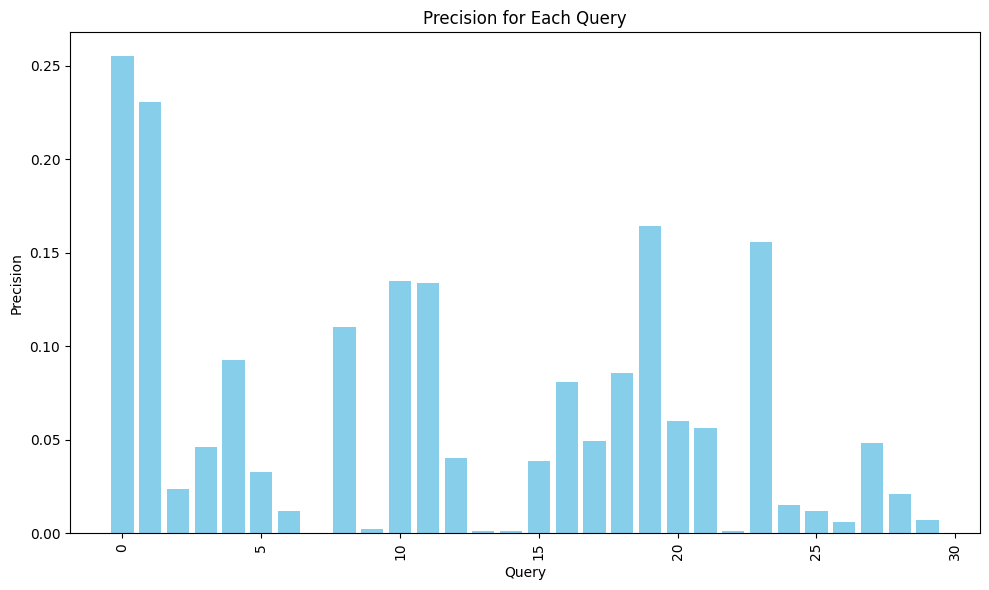

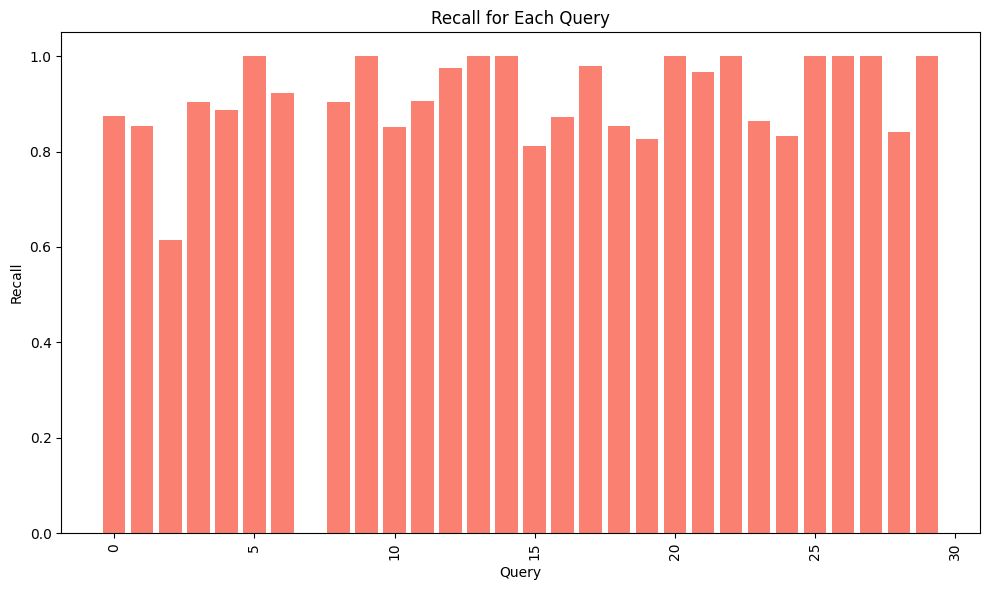

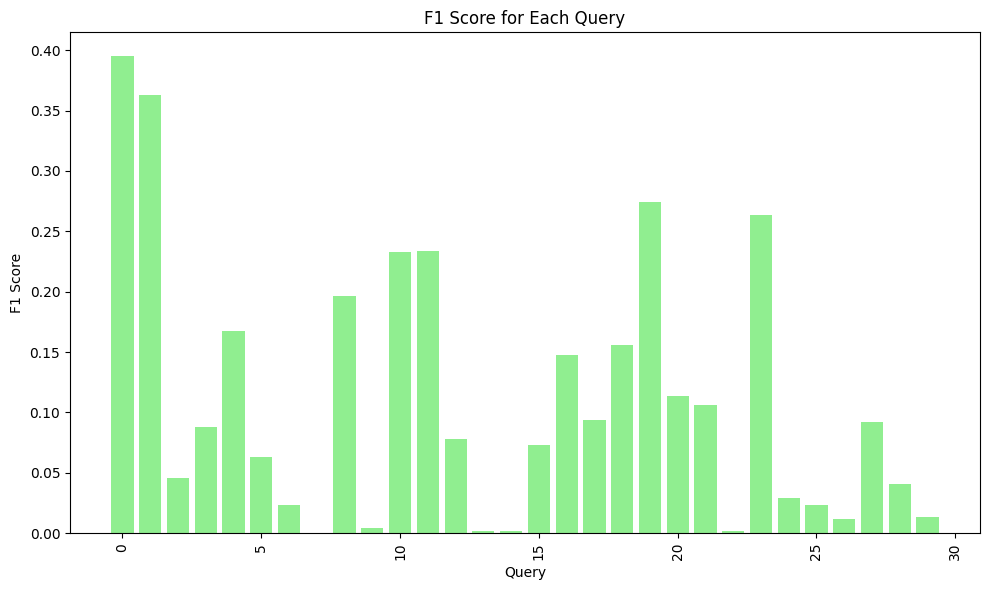

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot Precision
plt.figure(figsize=(10, 6))
plt.bar(metrics_df.index, metrics_df['Precision'], color='skyblue')
plt.xlabel('Query')
plt.ylabel('Precision')
plt.title('Precision for Each Query')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.bar(metrics_df.index, metrics_df['Recall'], color='salmon')
plt.xlabel('Query')
plt.ylabel('Recall')
plt.title('Recall for Each Query')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.bar(metrics_df.index, metrics_df['F1 Score'], color='lightgreen')
plt.xlabel('Query')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Query')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


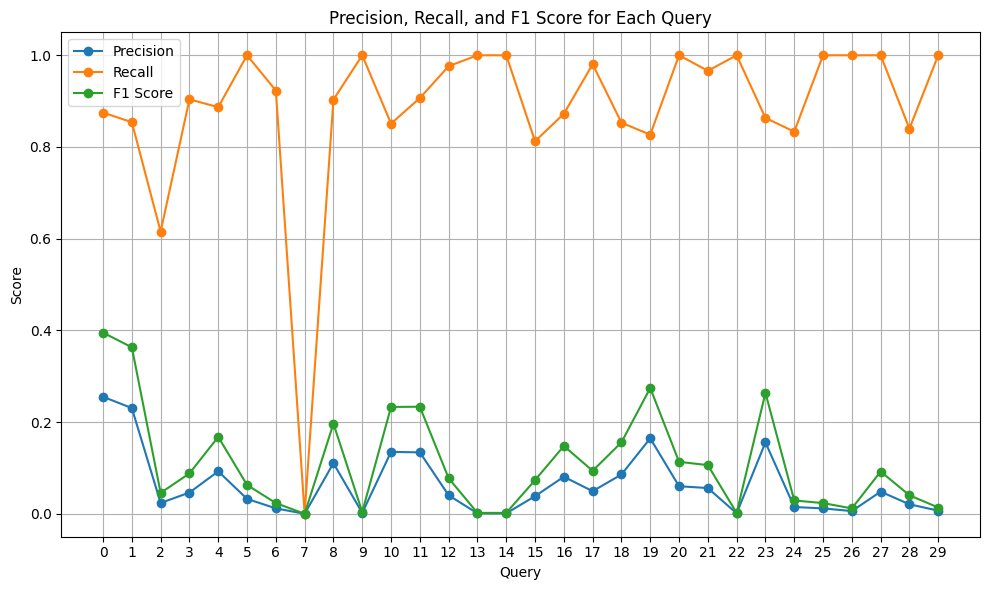

In [ ]:
# Import libraries
import matplotlib.pyplot as plt

# Extract data
query_numbers = range(len(metrics_df))
precisions = metrics_df['Precision']
recalls = metrics_df['Recall']
f1_scores = metrics_df['F1 Score']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(query_numbers, precisions, marker='o', linestyle='-', label='Precision')
plt.plot(query_numbers, recalls, marker='o', linestyle='-', label='Recall')
plt.plot(query_numbers, f1_scores, marker='o', linestyle='-', label='F1 Score')
plt.title("Precision, Recall, and F1 Score for Each Query")
plt.xlabel("Query")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.xticks(query_numbers)
plt.tight_layout()
plt.show()


*********************
# **5. User Interface:**

In [ ]:
# Imports
import ipywidgets as widgets
from IPython.display import display, clear_output, Image, HTML
import pandas as pd
import numpy as np
from nltk.corpus import wordnet
from collections import OrderedDict

# Helper function for synonyms
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word, pos=wordnet.NOUN):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)

# Assuming you've extracted 'general_cuisine' from 'cuisine_path'
# data['general_cuisine'] = data['cuisine_path'].apply(lambda x: x.split('/')[1] if '/' in x else x)
data['general_cuisine'] = data['cuisine_path'].apply(lambda x: x.split('/')[1] if '/' in x else x)

# UI Components
query_input = widgets.Textarea(
    value='',
    placeholder='Type your ingredients here, separated by commas',
    description='Ingredients:',
    disabled=False,
    layout={'width': '100%', 'height': '100px'},
    style={'description_width': 'initial'}
)

top_n_dropdown = widgets.Dropdown(
    options=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    value='10',
    description='Number of Results:',
    disabled=False,
    style={'description_width': 'initial'}
)
# Update top_n_dropdown to include an "All" option
top_n_dropdown.options = ['All', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Create a Dropdown for Sorting Options
sort_options_dropdown = widgets.Dropdown(
    options=[
        ('Score High to Low', ('score', 'desc')),
        ('Score Low to High', ('score', 'asc')),
        ('Rating High to Low', ('rating', 'desc')),
        ('Rating Low to High', ('rating', 'asc'))
    ],
    value=('score', 'desc'),  # Default value
    description='Sort By:',
    disabled=False,
    style={'description_width': 'initial'}
)

cuisine_dropdown = widgets.Dropdown(
    options=['All'] + sorted(data['general_cuisine'].unique().tolist()),
    value='All',
    description='Cuisine:',
    disabled=False,
    style={'description_width': 'initial'}
)

rating_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=5,
    step=0.1,
    description='Minimum Rating:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'}
)

search_button = widgets.Button(
    description="Search Recipes",
    button_style='success',
    tooltip='Click to search recipes',
    icon='search'
)
# Function to create and display a "pop-up" for recipe details
def create_popup(index):
    with output_area:
        clear_output()
        details = recipes[index]['details']
        display(widgets.HTML(value=f"<b>Details:</b> {details}"))
        close_button = widgets.Button(description="Close")
        close_button.on_click(lambda b: output_area.clear_output())
        display(close_button)

output_area = widgets.Output()

# Advanced Options Accordion
advanced_options = widgets.Accordion(children=[widgets.VBox([top_n_dropdown, cuisine_dropdown, rating_slider])])
advanced_options.set_title(0, 'Advanced Options')
advanced_options.selected_index = None

# Collapsible Display Function
def display_collapsible_results(ranked_docs, filtered_data):
    accordion = widgets.Accordion(children=[widgets.Output() for _ in ranked_docs])
    for i, (recipe_name, ingredients, score, url, rating) in enumerate(ranked_docs):
        accordion.set_title(i, f'{recipe_name} (Score: {score:.4f}, Rating: {rating:.1f})')
        with accordion.children[i]:
            print(f'Ingredients: {ingredients}')
            display(HTML(f'<a href="{url}" target="_blank">Recipe</a>'))
            if 'img_src' in filtered_data.columns:
                image_url = filtered_data[filtered_data['recipe_name'] == recipe_name]['img_src'].iloc[0]
                display(Image(url=image_url, width=200, height=200))
    display(accordion)

# Global variable to store the scores
search_scores = []

def on_search_button_clicked(b):
    global search_scores
    with output_area:
        clear_output()
        user_query = query_input.value
        q_terms = [term.strip() for term in user_query.split(',')]

        if len(q_terms) < 5:
            print("Please enter at least five ingredients.")
            return

        # Handle "All" selection
        top_n = top_n_dropdown.value
        top_n = None if top_n == 'All' else int(top_n)

        selected_cuisine = cuisine_dropdown.value
        min_rating = rating_slider.value
        sort_criterion, sort_order = sort_options_dropdown.value

        expanded_terms = q_terms.copy()
        for term in q_terms:
            synonyms = get_synonyms(term)
            expanded_terms += synonyms
        expanded_terms = list(OrderedDict.fromkeys(expanded_terms))

        # Assume 'bm25_dataframe' is defined earlier
        filtered_expanded_terms = [term for term in expanded_terms if term in bm25_dataframe.columns]
        expanded_terms_df = bm25_dataframe[filtered_expanded_terms]
        score_q_d = expanded_terms_df.sum(axis=1)

        if selected_cuisine != 'All':
            filtered_data = data[data['general_cuisine'] == selected_cuisine].copy()
        else:
            filtered_data = data.copy()

        filtered_data = filtered_data[filtered_data['rating'] >= min_rating]

        filtered_scores = score_q_d[filtered_data.index]
        ranked_docs = list(zip(filtered_data['recipe_name'], filtered_data['preprocessed_ingredients'],
                               filtered_scores, filtered_data['url'], filtered_data['rating']))

        # Apply Sorting
        if sort_criterion == 'score':
            ranked_docs.sort(key=lambda x: x[2], reverse=(sort_order == 'desc'))
        else:  # sort by rating
            ranked_docs.sort(key=lambda x: x[4], reverse=(sort_order == 'desc'))

        if top_n is not None:
            ranked_docs = ranked_docs[:top_n]

        if not ranked_docs:
            print("No results found. Try different ingredients or filters.")
        else:
            search_scores = ranked_docs
            display_collapsible_results(ranked_docs, filtered_data)

# Bind the event to the search button
search_button.on_click(on_search_button_clicked)
# Add the sort_options_dropdown to the advanced options accordion
advanced_options.children = [widgets.VBox([top_n_dropdown, cuisine_dropdown, rating_slider, sort_options_dropdown])]

# Now, display all UI components including the updated advanced options
display(query_input, advanced_options, search_button, output_area)

Textarea(value='', description='Ingredients:', layout=Layout(height='100px', width='100%'), placeholder='Type …

Accordion(children=(VBox(children=(Dropdown(description='Number of Results:', options=('All', '1', '2', '3', '…

Button(button_style='success', description='Search Recipes', icon='search', style=ButtonStyle(), tooltip='Clic…

Output()